# Package Install

In [ ]:
!pip install aum
!pip install transformers
!pip install nlp
!pip install datasets

# Import

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
from nlp import load_dataset
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from datasets import Dataset
import torch 
from aum import AUMCalculator, AUMRecord
import random
from tqdm.notebook import tqdm
from  matplotlib import pyplot
import seaborn
import os
import re

# Download and read Dataset

In [ ]:
!rm *.zip
!wget https://dl.fbaipublicfiles.com/glue/data/SST-2.zip
!unzip SST-2.zip

--2021-04-11 19:33:11--  https://dl.fbaipublicfiles.com/glue/data/SST-2.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7439277 (7.1M) [application/zip]
Saving to: ‘SST-2.zip’

SST-2.zip           100%[===================>]   7.09M  9.26MB/s    in 0.8s    

2021-04-11 19:33:12 (9.26 MB/s) - ‘SST-2.zip’ saved [7439277/7439277]

Archive:  SST-2.zip
replace SST-2/dev.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
train = Dataset.from_pandas(pd.read_csv("/content/SST-2/train.tsv",sep='\t',header='infer',index_col=0))
test = Dataset.from_pandas(pd.read_csv("/content/SST-2/test.tsv",sep='\t',header='infer',index_col=0))
dev = Dataset.from_pandas(pd.read_csv("/content/SST-2/dev.tsv",sep='\t',header='infer',index_col=0))

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
# Tokenize sentence
train_enc = tokenizer(train['sentence'], truncation=True, padding=True,max_length = 128)
test_enc = tokenizer(test['sentence'], truncation=True, padding=True,max_length = 128)
dev_enc = tokenizer(dev['sentence'], truncation=True, padding=True,max_length = 128)

# With Original DataSet (No AUM calculation)

## Dataset Preparation

In [ ]:
# Training data preparation
class SST(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = SST(train_enc, (torch.Tensor(train['label'])).long())
dev_dataset = SST(dev_enc, (torch.Tensor(dev['label'])).long())

## Training

In [ ]:
def training(model, bsize, n_epochs, train_data, lrate, optimizer, with_aum):
  dataloader = torch.utils.data.DataLoader(train_data, batch_size=bsize, shuffle=True)
  model.cuda()
  opt = optimizer(params = model.parameters(),lr=lrate)
  model.train()
  for i in tqdm(range(n_epochs)):
    total_train_loss = 0.0
    acc = 0.0
    for batch in tqdm(dataloader, leave=False):
      label = batch["labels"].cuda()
      data = batch["input_ids"].cuda()
      attention_mask = batch["attention_mask"].cuda()

      outputs = model(data, attention_mask=attention_mask, labels=label)
      acc += torch.sum(outputs.logits.argmax(dim=1)==label)
      loss = outputs.loss
      
      if with_aum:
        index = batch["index"].cuda()
        records = aum_calculator.update(outputs.logits, label, index)
      
      opt.zero_grad()
      loss.backward()
      opt.step()

      total_train_loss += loss

    print("Train_Loss:",total_train_loss / len(dataloader),"Acc: ", acc/len(train_data))
  
  if with_aum:
    if os.path.exists('/content/AUM/aum_values.csv'):
      os.remove('/content/AUM/aum_values.csv')
    aum_calculator.finalize()
  
  return model

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
BATCH_SIZE = 32
N_EPOCHS = 3
lr=1e-5
optimizer = torch.optim.Adam
model = training(model, BATCH_SIZE, N_EPOCHS, train_dataset, lr, optimizer, False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Train_Loss: tensor(0.2384, device='cuda:0', grad_fn=<DivBackward0>) Acc:  tensor(0.9022, device='cuda:0')


## Evaluation

In [ ]:
def evaluation(model, test_data, bsize):
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=bsize, shuffle=True)
  model.eval()
  acc = 0.0
  for batch in test_loader:
    input_ids = batch['input_ids'].cuda()
    attention_mask = batch['attention_mask'].cuda()
    labels = batch['labels'].cuda()
    outputs = model(input_ids, attention_mask, labels=labels)
    acc += torch.sum(outputs.logits.argmax(dim=-1)==labels)
  print("Test Acc: ", acc/len(test_data))

In [ ]:
evaluation(model, dev_dataset, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Test Acc:  tensor(0.9037, device='cuda:0')


# AUM Calculation

## Dataset Preparation 1

In [ ]:
num_classes = 2
fake_label = 2
N = len(train)
fakedata_count = int(N/(num_classes+1))

In [ ]:
random_index = random.sample(range(N), fakedata_count)

In [ ]:
# Add fake data and index
class SST_AUM(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, random_index):
        self.random_index = random_index
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if idx in self.random_index:
            item['labels'] = torch.tensor(fake_label)
        else:
            item['labels'] = torch.tensor(self.labels[idx])
        item['index'] = idx
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset_aum = SST_AUM(train_enc, (torch.Tensor(train['label'])).long(), random_index)

## Training 1

In [ ]:
save_dir = '/content/AUM'
aum_calculator = AUMCalculator(save_dir, compressed=True)

In [ ]:
# training
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=(num_classes+1))
BATCH_SIZE = 32
N_EPOCHS = 3
lr=1e-5
optimizer = torch.optim.Adam
model = training(model, BATCH_SIZE, N_EPOCHS, train_dataset_aum, lr, optimizer, True)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Train_Loss: tensor(0.8114, device='cuda:0', grad_fn=<DivBackward0>) Acc:  tensor(0.5943, device='cuda:0')


Train_Loss: tensor(0.7317, device='cuda:0', grad_fn=<DivBackward0>) Acc:  tensor(0.6335, device='cuda:0')


Train_Loss: tensor(0.6983, device='cuda:0', grad_fn=<DivBackward0>) Acc:  tensor(0.6476, device='cuda:0')



## Calculate Threshold 1

In [ ]:
def fetch_id(str):
  match = re.search(r'\d+', str)
  if match:
    return int(match.group(0))
  else:
    return None

In [ ]:
# also add flag for fake data
def csv_to_dataframe(path, fake_data_index):
  aum = pd.read_csv(path,sep=',',header='infer')
  aum['aum'] = aum['aum'].apply(float) #df['a'] = df['a'].apply(lambda x: x + 1)
  aum['sample_id'] = aum['sample_id'].apply(fetch_id)
  aum = aum.groupby(['sample_id'],as_index=False).mean()
  # create flag for fake data
  fake_data_flag = [1 if i in fake_data_index else 0 for i in range(len(aum))] # this takes alot of time
  aum["fake_data_flag"] = fake_data_flag
  return aum

In [ ]:
def plot_aum(aum_data):
  seaborn.set(style='ticks')
  fake= [0, 1]
  fg = seaborn.FacetGrid(data=aum_data, hue='fake_data_flag', hue_order=fake, aspect=1.61)
  fg.map(pyplot.scatter, 'aum', 'sample_id').add_legend()


In [ ]:
def calculate_threshold(aum_data,percentile):
  return aum_data[aum_data['fake_data_flag'] == 1].aum.quantile(percentile) 

In [ ]:
aum_data = csv_to_dataframe("/content/AUM/aum_values.csv", random_index)

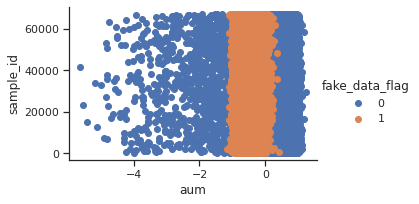

In [ ]:
plot_aum(aum_data)

In [ ]:
#99th percentile
threshold = calculate_threshold(aum_data, 0.7) 

## Filter Data 1

In [ ]:
filter_data1 = list(aum_data[(aum_data["fake_data_flag"] == 0) & (aum_data['aum'] < threshold)]["sample_id"])

In [ ]:
len(filter_data1)

1731

## Dataset Preparation 2

In [ ]:
!cat /var/log/colab-jupyter.log

cat: /var/log/colab-jupyter.log: No such file or directory


In [ ]:
# remaining data
temp = set(range(N)) - set(random_index)
random_index_2 = random.sample(temp, fakedata_count)
train_dataset_aum_2 = SST_AUM(train_enc, (torch.Tensor(train['label'])).long(), random_index_2)

## Training 2 (To find mislabed in altered data)

In [ ]:
# training
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=(num_classes+1))
BATCH_SIZE = 32
N_EPOCHS = 5
lr=1e-5
optimizer = torch.optim.Adam
model = training_with_aum(model, BATCH_SIZE, N_EPOCHS, train_dataset_aum_2, lr, optimizer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Train_Loss: tensor(0.8139, device='cuda:0', grad_fn=<DivBackward0>) Acc:  tensor(0.5934, device='cuda:0')


Train_Loss: tensor(0.7345, device='cuda:0', grad_fn=<DivBackward0>) Acc:  tensor(0.6314, device='cuda:0')


Train_Loss: tensor(0.7000, device='cuda:0', grad_fn=<DivBackward0>) Acc:  tensor(0.6451, device='cuda:0')


Train_Loss: tensor(0.6742, device='cuda:0', grad_fn=<DivBackward0>) Acc:  tensor(0.6581, device='cuda:0')


Train_Loss: tensor(0.6515, device='cuda:0', grad_fn=<DivBackward0>) Acc:  tensor(0.6699, device='cuda:0')



## threshold calculation 2

In [ ]:
aum_data = csv_to_dataframe("/content/AUM/aum_values.csv", random_index_2)

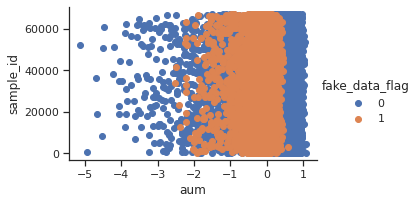

In [ ]:
plot_aum(aum_data)
threshold = calculate_threshold(aum_data, 0.7)

## Final Data Filter

In [ ]:
temp = list(aum_data[(aum_data["fake_data_flag"] == 0) & (aum_data['aum'] < threshold)]["sample_id"])

In [ ]:
mislabelled_data = set(filter_data1).union(set(temp))

In [ ]:
len(mislabelled_data)

3739

# Train on filter data

## Dataset Preparation

In [ ]:
train_dataset_filter = SST_AUM(train_enc, (torch.Tensor(train['label'])).long(), mislabelled_data)